<a href="https://colab.research.google.com/github/MedAmine-SUDO/Tunisian-License-Plate-Recognition/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In case you got an error "Mask RCNN is not installed" you have to change directory to Mask_RCNN folder and run these commands:

1.   !pip install -r requirements.txt
2.   !python setup.py install



In [ ]:
from os import listdir
import numpy as np
from numpy import expand_dims
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from PIL import Image
import cv2
import math
from scipy import ndimage
from keras.models import load_model
from google.colab.patches import cv2_imshow
import imutils
from matplotlib import pyplot as plt
from os import listdir

In [248]:
from flask import Flask, render_template, request, url_for, jsonify
from flask_ngrok import run_with_ngrok
from flask import jsonify

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://d6c601cccf38.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [12/Jul/2020 15:35:19] "POST / HTTP/1.1" 405 -


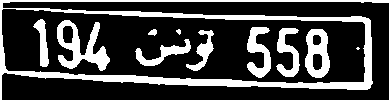

127.0.0.1 - - [12/Jul/2020 15:36:26] "POST /predict HTTP/1.1" 200 -


In [252]:
app = Flask(__name__)
run_with_ngrok(app)   #starts ngrok when the app is run

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    yhat, image = detectPlate(request.files['image'])
    l = firstCrop(image, yhat)
    segmentNumber(l[0])
    pl = listdir(DIGITS_PATH)
    pl = [(lambda x: int(x[:-4]))(x) for x in pl]
    pl = sorted(pl)
    res = recognize(pl)
    return jsonify(res)
    
if __name__ == "__main__":
    app.run()

In [15]:
cd ..

/content/drive/My Drive/LicensePlateProject


In [16]:
#Ensure that you are in the project directory
SUBMISSION_IMAGES = "./SubmissionImages/"

In [17]:
# define a configuration for the model
class LicensePlateConfig(Config):
	# define the name of the configuration
	NAME = "LicensePlate_cfg"
	# number of classes (background + License Plate)
	NUM_CLASSES = 1 + 1
	# number of training steps per epoch
	STEPS_PER_EPOCH = 131
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

In [18]:
# prepare config
config = LicensePlateConfig()

In [ ]:
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=config)

In [ ]:
model.load_weights("./licenseplate_cfg20200509T2207/mask_rcnn_licenseplate_cfg_0031.h5", by_name=True)

In [215]:
def detectPlate(imagePath):
    #Detecting License Plate
    #image = pyplot.imread(SUBMISSION_IMAGES+str(imageNum)+".jpg")
    image = pyplot.imread(imagePath)
    # convert pixel values (e.g. center)
    scaled_image = mold_image(image, config)
    # convert image into one sample
    sample = expand_dims(scaled_image, 0)
    # make prediction
    yhat = model.detect(sample, verbose=0)[0]

    return yhat, image

In [173]:
def firstCrop(img, predictions):
    firstCrop = []
    for box in predictions['rois']:
        # get coordinates
        y1, x1, y2, x2 = box
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        if width < height:
            continue
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        xtop = x1
        ytop = y1
        xbottom = x2
        ybottom = y2
        firstCrop.append(img[ytop:ybottom, xtop:xbottom])
        cv2.rectangle(img,(xtop,ytop),(xbottom,ybottom),(0,255,0),0)
    return firstCrop

In [174]:
yhat, image = detectPlate(904)
l = firstCrop(image, yhat)

In [246]:
def segmentNumber(image):
    (h, w, d) = image.shape
    ratio = w/h
    img = cv2.resize(image, (int(100*ratio), 100))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (3,3), 0)
    img2 = img.copy()
    img2 = cv2.adaptiveThreshold(img2, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)
    img2 = cv2.erode(img2, None, iterations=1)
    cnts = cv2.findContours(img2.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    digitCnts = []

    img3 = img2.copy()
    img3 = cv2.cvtColor(img3, cv2.COLOR_GRAY2BGR)
    i=0
    for file in os.listdir(DIGITS_PATH):
        os.remove(DIGITS_PATH+file)
        
    for c in cnts:
        (cx, cy, cw, ch) = cv2.boundingRect(c)
        #if ((cw >= w*0.05) and (cw <= w*0.5) and (ch >= h*0.5)):
        if ch >= 1.5*cw and ((cx > 10 and cx < 90) or (cx > 100 and cx < 500)):
            digitCnts.append(c)
            i+=1
            cv2.rectangle(img3, (cx,cy), (cx+cw,cy+ch), (0,255,0), 1)
            cv2.imwrite(DIGITS_PATH+str(cx)+'.jpg',img3[cy:cy+ch, cx:cx+cw])
    cv2_imshow(img3)


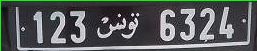

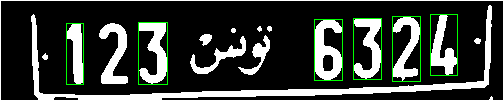

In [201]:
cv2_imshow(l[0])
segmentNumber(l[0])

In [135]:
DIGITS_PATH = "./PlateDigits/"

In [54]:
MODEL_PATH = './model_02.h5'

In [ ]:
from keras.models import load_model
rec_model = load_model(MODEL_PATH)

In [59]:
def getBestShift(img):
    cy,cx = ndimage.measurements.center_of_mass(img)

    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty

def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted

In [202]:
pl = listdir(DIGITS_PATH)
pl = [(lambda x: int(x[:-4]))(x) for x in pl]
pl = sorted(pl)

In [203]:
print(pl)

[66, 138, 314, 353, 392, 430]


In [236]:
def recognize(digitList):
    licPlate = []
    for im in digitList:
        gray = cv2.imread(DIGITS_PATH+str(im)+'.jpg', cv2.IMREAD_GRAYSCALE)
        gray = cv2.resize(gray, (28, 28))  # 255-gray for inverting black and white
        (thresh, gray) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        flatten = gray.flatten() / 255.0

        while np.sum(gray[0]) == 0:
            gray = gray[1:]

        while np.sum(gray[:,0]) == 0:
            gray = np.delete(gray,0,1)

        while np.sum(gray[-1]) == 0:
            gray = gray[:-1]

        while np.sum(gray[:,-1]) == 0:
            gray = np.delete(gray,-1,1)

        rows,cols = gray.shape
        if rows > cols:
            factor = 20.0/rows
            rows = 20
            cols = int(round(cols*factor))
            gray = cv2.resize(gray, (cols,rows))
        else:
            factor = 20.0/cols
            cols = 20
            rows = int(round(rows*factor))
            gray = cv2.resize(gray, (cols, rows))

        colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
        rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
        gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')

        shiftx,shifty = getBestShift(gray)
        shifted = shift(gray,shiftx,shifty)
        gray = shifted

        img = gray.reshape(1,1,28,28).astype('float32')
        img = img / 255
        prediction = rec_model.predict_classes(img)
        licPlate.append(prediction[0])
    if(len(licPlate) == 6):
        licPlate.insert(2,'TN')
        #print(licPlate)
        License = ''.join(map(str, licPlate))
    else:
        licPlate.insert(3, 'TN')
        #print(licPlate)
        License = ''.join(map(str, licPlate))

    return License

In [212]:
print(recognize(pl))

13TN6326
